# MNIST Data - Sequential API
- This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools 
import numpy as np

## Data

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train.astype(np.float32) / 255.0, X_test.astype(np.float32)/ 255.0

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


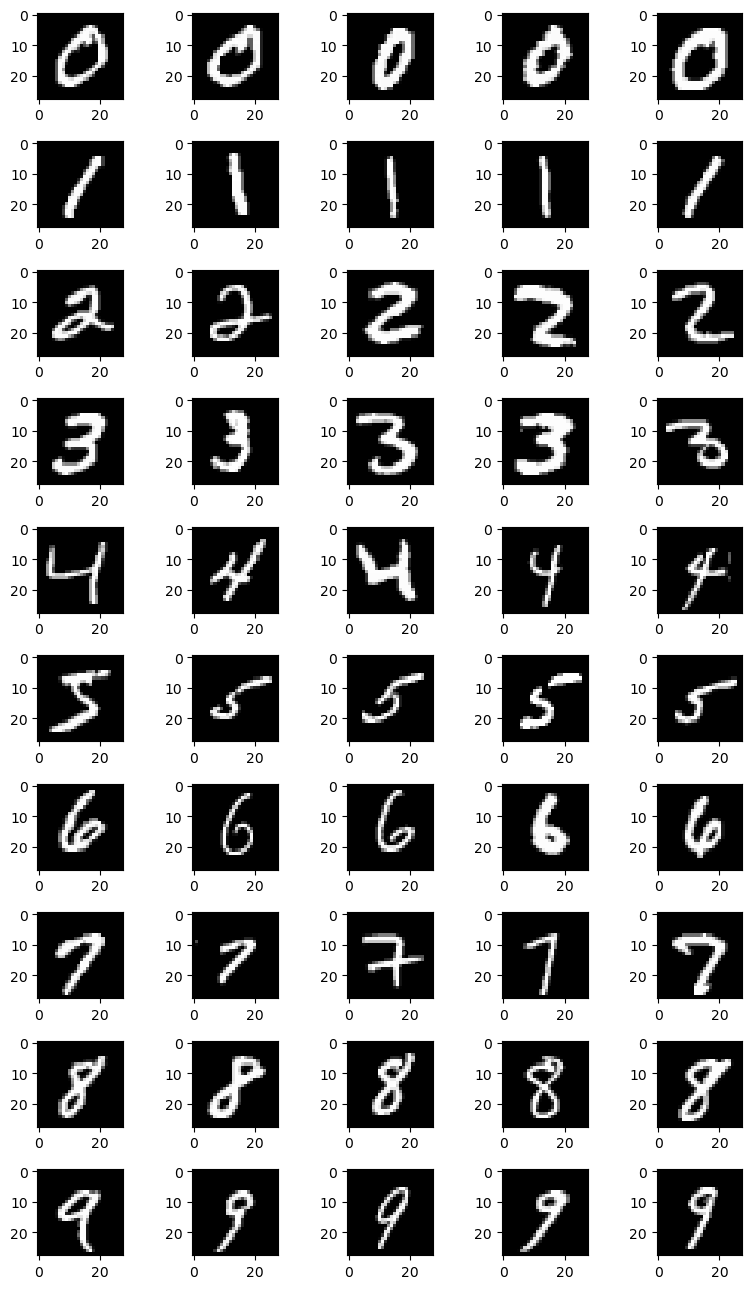

In [4]:
fig, axes = plt.subplots(10,5, figsize=(8,13))
for num in range(10):
    x_plot = X_train[y_train==num]
    for idx in range(np.array(axes).shape[1]):
        axes[num][idx].imshow(x_plot[idx], cmap='gray')
fig.tight_layout()
plt.show()

## Model building
- Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [5]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28,28)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

- For each example the model returns a vector of "[logits](https://developers.google.com/machine-learning/glossary#logits)" or "[log-odds](https://developers.google.com/machine-learning/glossary#log-odds)" scores, one for each class.

In [6]:
y_hat = model(X_train[:1])
print(y_hat.numpy())

[[ 0.01406759 -0.1024453  -0.501123   -0.35176346 -0.21108237  0.8334273
  -0.7235006   0.67615247  0.3655746  -0.57536495]]


- The `tf.nn.softmax` function converts these logits to "probabilities" for each class
- It is possible to bake this `tf.nn.softmax` in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output. 

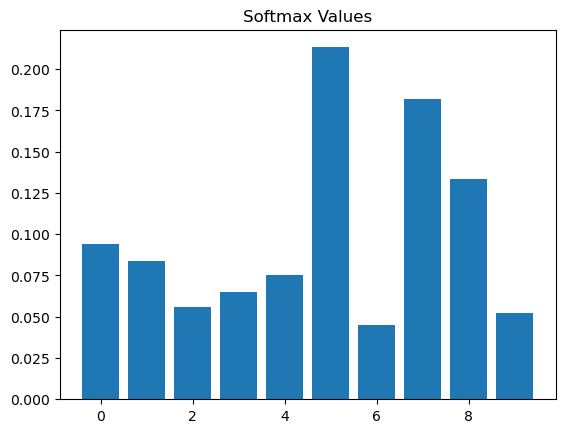

In [7]:
y_hat_softmax = tf.nn.softmax(y_hat)
#print(y_hat_softmax.numpy())

yp = y_hat_softmax.numpy()[0]
xp = list(range(yp.shape[0]))
plt.bar(xp, yp)
plt.title('Softmax Values')
plt.show()

## Loss function
- The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and returns a scalar loss for each example.
- If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their `from_logits = True`
    - https://medium.com/deep-learning-with-keras/which-activation-loss-functions-part-a-e16f5ad6d82a


In [8]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

- This loss is equal to the negative log probability of the true class:
It is zero if the model is sure of the correct class.
- This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.
- $l(w) =  -y \ln(\hat{y}) - (1-y) \ln(1-\hat{y})  $  where $y=1$ and $\hat{y} = 1/10$

In [9]:
loss_fn([0],y_hat).numpy()

2.3647542

## Compile model
- Prepare for fitting

In [10]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.trainable_variables[0]

<tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
array([[ 0.02827693, -0.05273496,  0.0441205 , ..., -0.02271262,
        -0.02970593,  0.05925976],
       [ 0.02268823,  0.04178647,  0.00687616, ...,  0.04857097,
         0.06005225, -0.01736013],
       [-0.04926014,  0.02403211, -0.02786533, ...,  0.01263861,
        -0.06179645,  0.02528603],
       ...,
       [-0.00542464,  0.02234633,  0.06275777, ..., -0.03005491,
        -0.0769564 , -0.00077584],
       [-0.05433082,  0.06456599,  0.03704851, ...,  0.01258111,
         0.02324095, -0.06684282],
       [-0.01968608,  0.06518804, -0.01762487, ...,  0.07414944,
        -0.03108537,  0.01116048]], dtype=float32)>

## Training (Fitting)
- The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [13]:
tf_fit = model.fit(X_train, y_train, validation_split=0.1, epochs=5)

Epoch 1/5
1688/1688 [==============================] - 1s 688us/step - loss: 0.2697 - accuracy: 0.9224 - val_loss: 0.1206 - val_accuracy: 0.9678
Epoch 2/5
1688/1688 [==============================] - 1s 627us/step - loss: 0.1171 - accuracy: 0.9642 - val_loss: 0.0946 - val_accuracy: 0.9692
Epoch 3/5
1688/1688 [==============================] - 1s 645us/step - loss: 0.0816 - accuracy: 0.9755 - val_loss: 0.0804 - val_accuracy: 0.9783
Epoch 4/5
1688/1688 [==============================] - 1s 636us/step - loss: 0.0589 - accuracy: 0.9820 - val_loss: 0.0786 - val_accuracy: 0.9757
Epoch 5/5
1688/1688 [==============================] - 1s 639us/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0735 - val_accuracy: 0.9793


In [14]:
for key, val in tf_fit.history.items():
    print( f'{key:20s}: {[ f"{i:3.2f}" for i in val]}')


loss                : ['0.27', '0.12', '0.08', '0.06', '0.05']
accuracy            : ['0.92', '0.96', '0.98', '0.98', '0.99']
val_loss            : ['0.12', '0.09', '0.08', '0.08', '0.07']
val_accuracy        : ['0.97', '0.97', '0.98', '0.98', '0.98']


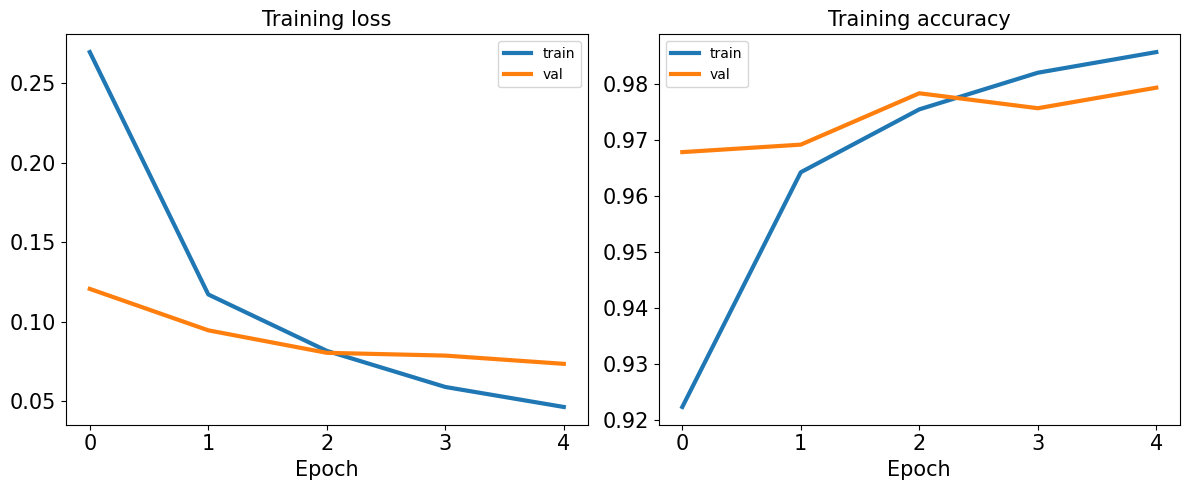

In [15]:
hist = tf_fit.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.plot(hist['val_loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(['train','val'])

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.plot(hist['val_accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
ax.legend(['train','val'])

#plt.savefig('mnist1.pdf')

plt.show()

## Evaluation
- The `Model.evaluate` method checks the models performance.

In [16]:
model.evaluate(X_test,  y_test)

313/313 [==============================] - 0s 417us/step - loss: 0.0779 - accuracy: 0.9761


[0.07789266109466553, 0.9761000275611877]

In [17]:
y_hat = model(X_test)
print(y_hat.shape)
print(y_hat.numpy()[:2])

(10000, 10)
[[ -5.006388    -6.1315513   -0.09283189   3.3662903  -14.321909
   -6.141413   -18.106554    12.065161    -4.038123    -0.53902096]
 [ -6.563505     1.716907    13.012509     1.5894221  -17.90341
   -2.6634212   -5.9231443  -11.770182    -2.500982   -15.285275  ]]


Return a probability, you can wrap the trained model, and attach the softmax to it:

In [18]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
y_hat_softmax = probability_model(X_test[:1])
print(y_hat_softmax.numpy())

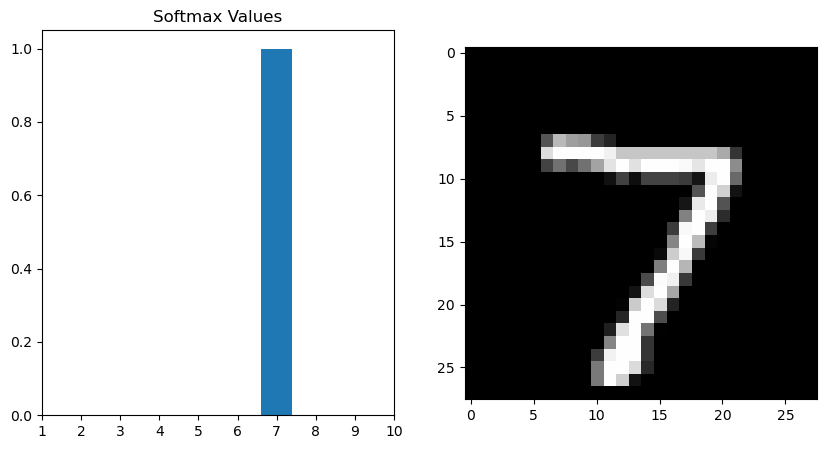

In [37]:
x_ticklabel = [i + 1 for i in range(10)]
fig, axes = plt.subplots(1,2, figsize=(10,5))
yp = y_hat_softmax.numpy()[0]
xp = list(range(yp.shape[0]))
axes[0].bar(xp, yp)
axes[0].set_title('Softmax Values')
axes[0].set_xticks(x_ticklabel)
axes[0].set_xticklabels(x_ticklabel)
axes[0].set_xlim([1,10])
axes[1].imshow(X_test[0], cmap='gray')
plt.show()

In [19]:
# Find misclassification
y_pred_tf = probability_model(X_test)
y_pred_tf.numpy().shape

y_pred = tf.math.argmax(y_pred_tf,axis=1).numpy()
print(y_pred.shape)
print(y_test.shape)

loc = y_pred != y_test
print(f'Missclassification = {loc.sum()}')

(10000,)
(10000,)
Missclassification = 239


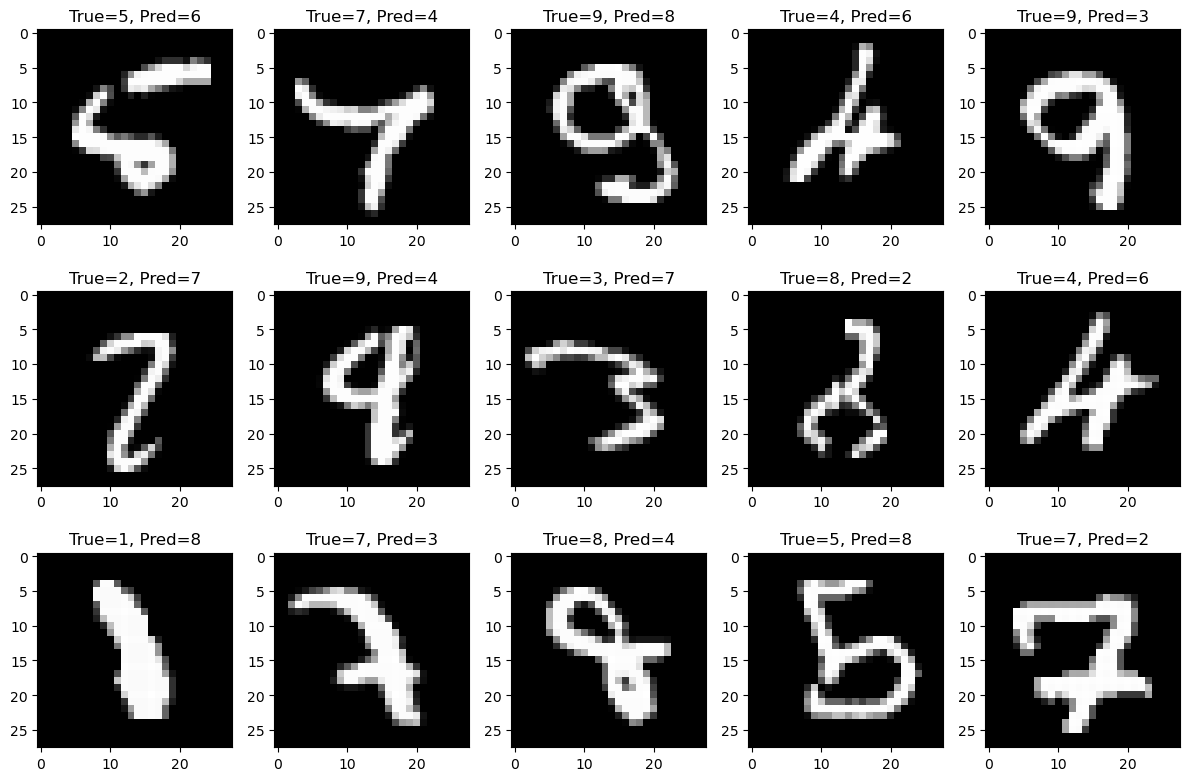

In [20]:
fig, axes2D = plt.subplots(3,5, figsize=(12,8))
axes = list(itertools.chain.from_iterable(axes2D)) # Flatten 2D list
X_test_miss = X_test[loc]
y_test_miss = y_test[loc]
y_pred_miss = y_pred[loc]
for idx, ax in enumerate(axes):
    ax.imshow(X_test_miss[idx], cmap='gray')
    ax.set_title(f'True={y_test_miss[idx]}, Pred={y_pred_miss[idx]}')
fig.tight_layout()
plt.show()